# 1. Datenaufbereitung

In [1]:
pip install --upgrade --force-reinstall gensim

  Using cached gensim-4.3.1-cp39-cp39-win_amd64.whl (24.0 MB)
  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Using cached scipy-1.10.1-cp39-cp39-win_amd64.whl (42.5 MB)
  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.3.0
    Uninstalling smart-open-6.3.0:
      Successfully uninstalled smart-open-6.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade --force-reinstall numpy

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
# from google.colab import files 
# uploaded = files.upload()

In [4]:
import pandas as pd

In [5]:
def helper(column):
    return str(column).split(",")

# Das kann später raus
def open_csv_default():
    df_data = pd.read_csv("naukri_data_science_jobs_india.csv")
    df_data = df_data.drop(columns=['Company', 'Location', 'Job Experience'])
    df_data["Skills/Description"] = df_data["Skills/Description"].apply(lambda x: helper(x))
    return df_data

# Das kann später raus
def open_csv_clean():
    df_data = pd.read_csv("naukri_data_science_jobs_india_cleaned.csv")
    formatted = df_data.values.tolist()
    return formatted

def open_csv_clustered():
    df_data = pd.read_csv("naukri_data_science_jobs_india_cleaned_clusterd.csv")
    df_data = df_data.drop(columns=['Job_Role', 'lda_score'])
    df_data = df_data[['lda_topic', 'Skills/Description']]
    return df_data

# 2. Methodendeklaration, Hilfsfunktionen unsw.

In [6]:
### Training uses the Doc2Vec or Word2Vec model which simply embeds words according to how often they occur together (ignoring order afaik)
## Adapt vector size and epochs in training once data set is complete

from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import ast
import numpy

def trainWord2Vec(data):
# Preprocess the data and create list of skills (this training does NOT include jobs!)
    tagged_data = [ast.literal_eval(skills) for job, skills in data]

# Train the Word2Vec model, try different vector sizes for interesting effects in similarities
    model = Word2Vec(vector_size=50, min_count=1, workers=4, epochs=20)
    model.build_vocab(tagged_data)

    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model

def trainDoc2Vec(data):
    tagged_data = [TaggedDocument(words=ast.literal_eval(skills), tags=[job]) for job, skills in data[:]]

# Train the Doc2Vec model
    model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
    model.build_vocab(tagged_data)

    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    return model

# helper method to calculate average embedding vector of a list of string skills, filters out skills unknown to the model
def averageOfSkills(model, input, axis = 0):
    vectors = [model.wv[i] for i in input if model.wv.has_index_for(i)]
    if(len(vectors) == 0):
        return numpy.zeros(len(model.wv[0]))
    
    return numpy.average(vectors, axis = axis)

In [7]:
import numpy

def calcAvgEmbeddings(model, data):

    # Tests for the embedding go here
    print(model.wv.most_similar("neural_networks", topn = 5))

    #cosine distance
    print(model.wv.distance("finance", "machine_learning"))
    print(model.wv.distance("ai", "machine_learning"))
    print(model.wv.distance("business_intelligence", "management"))
    print(model.wv.distance('corporate_governance', 'ai'))
    #euclidean distance
    #print(numpy.linalg.norm(model.wv["statistics"] - model.wv["machine_learning"]))

    # split the tuples
    job_titles, skills = list(zip(*data))
    # calculate the average skill vector of every job offering / person and zip back together
    skillAverages = [averageOfSkills(model, ast.literal_eval(skill)) for skill in skills]
    data_averaged = list(zip(job_titles, skillAverages))

    return (skillAverages, data_averaged)

# This gives us a list of job offerings and average embeddings. 
# Could be used as input to a graph neural network or knowledge graph?
# Is used below to classify immediately

In [8]:
# simply suggest smallest distance to user's average ("Option 2") using word2Vec
import itertools
import operator
from scipy.spatial.distance import cdist

def prepareOption2(data):

    model = trainWord2Vec(data)
    skillAverages, data_averaged = calcAvgEmbeddings(model, data)

    # sort before grouping
    data_averaged.sort(key=operator.itemgetter(0))
    # Group by job title, take the average embedding of everyone with that title and make a dictionary (maps job title to average embedding)
    job_averages = {key : numpy.average(list(zip(*list(value)))[1], axis = 0)
        for key, value in itertools.groupby(data_averaged, lambda x: x[0])}

    #keep keys and values
    keys = list(job_averages.keys())
    values = list(job_averages.values())
    # easy access to the avg vector
    #print(job_averages['Advisor, Data Science'])
    
    # model.save("word2vec_model_option2.bin")

    return job_averages, keys, values, model

# usage in next cells

In [9]:
# "Option 3" could be using the embedding learned by Doc2Vec and doing the same manual averaging as Option 2 for "learning" the correlation of job to skills
import itertools
import operator
from scipy.spatial.distance import cdist
import numpy as np

def prepareOption3(data):
#if !data:
#  data = open_csv_clean()
    model = trainDoc2Vec(data)
    skillAverages, data_averaged = calcAvgEmbeddings(model, data)

    # sort before grouping
    data_averaged.sort(key=operator.itemgetter(0))
    # Group by job title, take the average embedding of everyone with that title and make a dictionary (maps job title to average embedding)
    job_averages = {key : numpy.average(list(zip(*list(value)))[1], axis = 0)
        for key, value in itertools.groupby(data_averaged, lambda x: x[0])}

    #keep keys and values
    keys = list(job_averages.keys())
    values = list(job_averages.values())
    
    return job_averages, keys, values, model

# 3. Training

In [10]:
# Proper testing
import heapq

# divide data into 75 train, 25 test
def train_test_split(df, frac=0.25):
    # get random sample 
    test = df.sample(frac=frac, axis=0)
    # get everything but the test sample
    train = df.drop(index=test.index)
    return train, test


df = open_csv_clustered()
df_data, df_test = train_test_split(df)
formatted_data = df_data.values.tolist()
formatted_test = df_test.values.tolist()
jobs, skills = list(zip(*formatted_test))
skills = [ast.literal_eval(skill) for skill in skills]

# Option 1: Doc2Vec
model_option1 = trainDoc2Vec(formatted_data)

# Option 2: Word2Vec
job_averages_option2, keys_option2, values_option2, model_option2 = prepareOption2(formatted_data)

# Option 3: Doc2Vec Embedding
job_averages_option3, keys_option3, values_option3, model_option3 = prepareOption3(formatted_data)



[('text_mining', 0.9840205907821655), ('computer_vision', 0.9653641581535339), ('logistic_regression', 0.9486359357833862), ('image_processing', 0.9478869438171387), ('deep_learning', 0.9476275444030762)]
0.7342003881931305
0.41722267866134644
0.4114232063293457
0.5586076080799103
[('computer_vision', 0.9629616737365723), ('advanced_analytics', 0.961156964302063), ('big_data_analytics', 0.9560986161231995), ('risk_analytics', 0.9463423490524292), ('construction', 0.9426249265670776)]
0.5141088664531708
0.38097262382507324
0.3912978768348694
0.6066699028015137


# 4. Testing

In [70]:
# Option 1: Doc2Vec
predictions_option1 = []
for skills_example in skills:
    infer_vector_option1 = model_option1.infer_vector(skills_example)
    similar_jobs_option1 = model_option1.dv.most_similar([infer_vector_option1], topn=3)
    predicted_jobs_option1 = [job for job, similarity in similar_jobs_option1]
    predictions_option1.append(predicted_jobs_option1)

# Option 2: Word2Vec
predictions_option2 = []
for skills_example in skills:
    avg_option2 = averageOfSkills(model_option2, skills_example)
    distVec_option2 = cdist([avg_option2], values_option2)
    topJobs_option2 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option2.transpose(), keys_option2))]
    predictions_option2.append(topJobs_option2)

# Option 3: Doc2Vec Embedding
predictions_option3 = []
for skills_example in skills:
    avg_option3 = averageOfSkills(model_option3, skills_example)
    distVec_option3 = cdist([avg_option3], values_option3)
    topJobs_option3 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option3.transpose(), keys_option3))]
    predictions_option3.append(topJobs_option3)

In [82]:
'''
• True positive (TP): A test result that correctly indicates the presence of a condition or characteristic.
• False positive (FP): A test result that wrongly indicates that a particular condition or attribute is present.
'''

# job[0] is the label/correct job category
ground_truth_labels = [job[0] for job in formatted_test]

# Option 1
tp_option1 = 0
fp_option1 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option1, ground_truth_labels):
    if ground_truth in predicted_jobs:
        tp_option1 += 1
    else:
        fp_option1 += 1

# Option 2
tp_option2 = 0
fp_option2 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option2, ground_truth_labels):
    if ground_truth in predicted_jobs:
        tp_option2 += 1
    else:
        fp_option2 += 1

# Option 3
tp_option3 = 0
fp_option3 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option3, ground_truth_labels):
    if ground_truth in predicted_jobs:
        tp_option3 += 1
    else:
        fp_option3 += 1

print("Option 1:")
print("True Positives (TP):", tp_option1)
print("False Positives (FP):", fp_option1)

print("\nOption 2:")
print("True Positives (TP):", tp_option2)
print("False Positives (FP):", fp_option2)

print("\nOption 3:")
print("True Positives (TP):", tp_option3)
print("False Positives (FP):", fp_option3)


Option 1:
True Positives (TP): 2023
False Positives (FP): 743

Option 2:
True Positives (TP): 2477
False Positives (FP): 289

Option 3:
True Positives (TP): 2445
False Positives (FP): 321


In [84]:
'''
• Accuracy (ACC): The proportion of correct predictions (both true positives and true negatives) out of all predictions made by the model.
• Precision or positive predictive value (PPV): The proportion of true positives out of all positive predictions made by the model.
'''
# Calculate precision (PPV)
precision_option1 = tp_option1 / (tp_option1 + fp_option1)
precision_option2 = tp_option2 / (tp_option2 + fp_option2)
precision_option3 = tp_option3 / (tp_option3 + fp_option3)

# Calculate accuracy (ACC)
total_predictions = len(ground_truth_labels)
correct_predictions_option1 = tp_option1
correct_predictions_option2 = tp_option2
correct_predictions_option3 = tp_option3
accuracy_option1 = correct_predictions_option1 / total_predictions
accuracy_option2 = correct_predictions_option2 / total_predictions
accuracy_option3 = correct_predictions_option3 / total_predictions

print("Option 1:")
print("True Positives (TP):", tp_option1)
print("False Positives (FP):", fp_option1)
print("Precision (PPV):", precision_option1)
print("Accuracy (ACC):", accuracy_option1)

print("\nOption 2:")
print("True Positives (TP):", tp_option2)
print("False Positives (FP):", fp_option2)
print("Precision (PPV):", precision_option2)
print("Accuracy (ACC):", accuracy_option2)

print("\nOption 3:")
print("True Positives (TP):", tp_option3)
print("False Positives (FP):", fp_option3)
print("Precision (PPV):", precision_option3)
print("Accuracy (ACC):", accuracy_option3)

Option 1:
True Positives (TP): 2023
False Positives (FP): 743
Precision (PPV): 0.7313810556760665
Accuracy (ACC): 0.7313810556760665

Option 2:
True Positives (TP): 2477
False Positives (FP): 289
Precision (PPV): 0.8955169920462762
Accuracy (ACC): 0.8955169920462762

Option 3:
True Positives (TP): 2445
False Positives (FP): 321
Precision (PPV): 0.8839479392624728
Accuracy (ACC): 0.8839479392624728


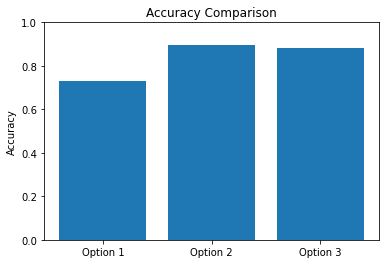

In [86]:
#Visualisierung der Ergebnisse
import matplotlib.pyplot as plt

# Accuracy values for the three options
accuracies = [accuracy_option1, accuracy_option2, accuracy_option3]

# Labels for the x-axis
options = ['Option 1', 'Option 2', 'Option 3']

# Plotting the bar graph
plt.bar(options, accuracies)
#plt.xlabel('Options')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim([0, 1])  # Set the y-axis limits between 0 and 1
plt.show()

In [63]:
# print(len(predictions_option1), len(predictions_option2), len(predictions_option3))
# print(len(formatted_test), len(formatted_data), len(df))
# print(predictions_option1)

# ground_truth_labels = [job[0] for job in formatted_test]
# len(ground_truth_labels)
# print(ground_truth_labels)

# 5. Ein Beispiel für Option 1, 2 und 3

In [11]:
skills_example = ['azure', 'azure', 'streaming', 'big_data']

# Option 1: Doc2Vec
infer_vector_option1 = model_option1.infer_vector(skills_example)
similar_jobs_option1 = model_option1.dv.most_similar([infer_vector_option1], topn=3)
predicted_jobs_option1 = [job for job, similarity in similar_jobs_option1]
print("Option 1 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match:", predicted_jobs_option1)
print("")

# Option 2: Word2Vec
avg_option2 = averageOfSkills(model_option2, skills_example)
distVec_option2 = cdist([avg_option2], values_option2)
topJobs_option2 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option2.transpose(), keys_option2))]
print("Option 2 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match:", topJobs_option2)
print("")

# Option 3: Doc2Vec Embedding
avg_option3 = averageOfSkills(model_option3, skills_example)
distVec_option3 = cdist([avg_option3], values_option3)
topJobs_option3 = [k for dist, k in heapq.nsmallest(3, zip(distVec_option3.transpose(), keys_option3))]
print("Option 3 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match:", topJobs_option3)
print("")


Option 1 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match: [1, 7, 6]

Option 2 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match: [0, 7, 1]

Option 3 Prediction: Given the skillset, it should belong to one of the following three groups beginning with the best match: [7, 0, 1]



# 6. Evaluierung mit weiterer Kennzahlen / Optional und nicht Fertig

In [12]:
# evaluation and assessment of binary classification models

'''
In the following, I will try to calculate:
•	Condition positive (P): The number of real positive cases in the data.
•	Condition negative (N): The number of real negative cases in the data.
•	True positive (TP): A test result that correctly indicates the presence of a condition or characteristic.
•	True negative (TN): A test result that correctly indicates the absence of a condition or characteristic.
•	False positive (FP): A test result that wrongly indicates that a particular condition or attribute is present.
•	False negative (FN): A test result that wrongly indicates that a particular condition or attribute is absent.
•	Sensitivity, recall, hit rate, or true positive rate (TPR): The proportion of true positives out of all actual positive cases.
•	Specificity, selectivity, or true negative rate (TNR): The proportion of true negatives out of all actual negative cases.
•	Precision or positive predictive value (PPV): The proportion of true positives out of all positive predictions made by the model.
•	Negative predictive value (NPV): The proportion of true negatives out of all negative predictions made by the model.
•	Miss rate or false negative rate (FNR): The proportion of false negatives out of all actual positive cases.
•	Fall-out or false positive rate (FPR): The proportion of false positives out of all actual negative cases.
•	False discovery rate (FDR): The proportion of false positives out of all positive predictions made by the model.
•	False omission rate (FOR): The proportion of false negatives out of all negative predictions made by the model.
•	Positive likelihood ratio (LR+): The ratio of true positive rate to false positive rate.
•	Negative likelihood ratio (LR-): The ratio of false negative rate to true negative rate.
•	Prevalence threshold (PT): A threshold value that balances sensitivity and specificity.
•	Threat score (TS) or critical success index (CSI): The proportion of true positives out of all positive and negative predictions made by the model.
•	Prevalence: The proportion of positive cases in the data.
•	Accuracy (ACC): The proportion of correct predictions (both true positives and true negatives) out of all predictions made by the model.
•	Balanced accuracy (BA): The average of sensitivity and specificity.
•	F1 score: The harmonic mean of precision and sensitivity, providing a single metric to balance both.
•	Phi coefficient (φ) or Matthews correlation coefficient (MCC): A correlation coefficient that takes into account true positives, true negatives, false positives, and false negatives.
•	Fowlkes-Mallows index (FM): A geometric mean of precision and sensitivity.
•	Informedness or bookmaker informedness (BM): The sum of true positive rate and true negative rate, minus 1.
•	Markedness (MK) or deltaP (Δp): The sum of positive predictive value and negative predictive value, minus 1.

'''

'\nIn the following, I will try to calculate:\n•\tCondition positive (P): The number of real positive cases in the data.\n•\tCondition negative (N): The number of real negative cases in the data.\n•\tTrue positive (TP): A test result that correctly indicates the presence of a condition or characteristic.\n•\tTrue negative (TN): A test result that correctly indicates the absence of a condition or characteristic.\n•\tFalse positive (FP): A test result that wrongly indicates that a particular condition or attribute is present.\n•\tFalse negative (FN): A test result that wrongly indicates that a particular condition or attribute is absent.\n•\tSensitivity, recall, hit rate, or true positive rate (TPR): The proportion of true positives out of all actual positive cases.\n•\tSpecificity, selectivity, or true negative rate (TNR): The proportion of true negatives out of all actual negative cases.\n•\tPrecision or positive predictive value (PPV): The proportion of true positives out of all posit

In [13]:
# formatted_test

In [14]:
# ground_truth_labels = [job[0] for job in formatted_test]
# print(ground_truth_labels)

In [40]:
# predicted_jobs_option1

In [79]:
'''
import csv

def save_predictions_to_csv(predictions, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(predictions)
    print("Predictions saved to CSV file successfully!")

# Usage example
#save_predictions_to_csv(predictions_option1, 'predictions_option1.csv')

ground_truth_labels = [job[0] for job in formatted_test]
def save_ground_truth_to_csv(ground_truth, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for label in ground_truth:
            writer.writerow([label])
    print("Ground truth saved to CSV file successfully!")

# Usage example
save_ground_truth_to_csv(ground_truth_labels, 'ground_truth.csv')
'''

'\nimport csv\n\ndef save_predictions_to_csv(predictions, file_path):\n    with open(file_path, \'w\', newline=\'\') as csvfile:\n        writer = csv.writer(csvfile)\n        writer.writerows(predictions)\n    print("Predictions saved to CSV file successfully!")\n\n# Usage example\n#save_predictions_to_csv(predictions_option1, \'predictions_option1.csv\')\n\nground_truth_labels = [job[0] for job in formatted_test]\ndef save_ground_truth_to_csv(ground_truth, file_path):\n    with open(file_path, \'w\', newline=\'\') as csvfile:\n        writer = csv.writer(csvfile)\n        for label in ground_truth:\n            writer.writerow([label])\n    print("Ground truth saved to CSV file successfully!")\n\n# Usage example\nsave_ground_truth_to_csv(ground_truth_labels, \'ground_truth.csv\')\n'

In [ ]:
'''
• True positive (TP): A test result that correctly indicates the presence of a condition or characteristic.
• True negative (TN): A test result that correctly indicates the absence of a condition or characteristic.
• False positive (FP): A test result that wrongly indicates that a particular condition or attribute is present.
• False negative (FN): A test result that wrongly indicates that a particular condition or attribute is absent.

'''

# job[0] is the label/correct job category
ground_truth_labels = [job[0] for job in formatted_test]

# Option 1
tp_option1 = 0
fp_option1 = 0
fn_option1 = 0
tn_option1 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option1, ground_truth_labels):
    if ground_truth in predicted_jobs:
        if ground_truth == predicted_jobs[0]:
            tp_option1 += 1
        else:
            fp_option1 += 1
    else:
        if ground_truth == predicted_jobs[0]:
            fn_option1 += 1
        else:
            tn_option1 += 1

# Option 2
tp_option2 = 0
fp_option2 = 0
fn_option2 = 0
tn_option2 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option2, ground_truth_labels):
    if ground_truth in predicted_jobs:
        if ground_truth == predicted_jobs[0]:
            tp_option2 += 1
        else:
            fp_option2 += 1
    else:
        if ground_truth == predicted_jobs[0]:
            fn_option2 += 1
        else:
            tn_option2 += 1

# Option 3
tp_option3 = 0
fp_option3 = 0
fn_option3 = 0
tn_option3 = 0

# Iterate over predicted job titles and ground truth labels
for predicted_jobs, ground_truth in zip(predictions_option3, ground_truth_labels):
    if ground_truth in predicted_jobs:
        if ground_truth == predicted_jobs[0]:
            tp_option3 += 1
        else:
            fp_option3 += 1
    else:
        if ground_truth == predicted_jobs[0]:
            fn_option3 += 1
        else:
            tn_option3 += 1

print("Option 1:")
print("True Positives (TP):", tp_option1)
print("False Positives (FP):", fp_option1)
print("False Negatives (FN):", fn_option1)
print("True Negatives (TN):", tn_option1)

print("\nOption 2:")
print("True Positives (TP):", tp_option2)
print("False Positives (FP):", fp_option2)
print("False Negatives (FN):", fn_option2)
print("True Negatives (TN):", tn_option2)

print("\nOption 3:")
print("True Positives (TP):", tp_option3)
print("False Positives (FP):", fp_option3)
print("False Negatives (FN):", fn_option3)
print("True Negatives (TN):", tn_option3)

In [16]:
'''
• True positive (TP): A test result that correctly indicates the presence of a condition or characteristic.
• True negative (TN): A test result that correctly indicates the absence of a condition or characteristic.
• False positive (FP): A test result that wrongly indicates that a particular condition or attribute is present.
• False negative (FN): A test result that wrongly indicates that a particular condition or attribute is absent.

'''
# job[0] is the label/correct job category
ground_truth_labels = [job[0] for job in formatted_test]


# Calculate the total number of samples in your dataset
total_samples = len(df_test)

# Option 1
tp_option1 = len(set(predicted_jobs_option1) & set(ground_truth_labels))
fp_option1 = len(predicted_jobs_option1) - tp_option1
fn_option1 = len(ground_truth_labels) - tp_option1
tn_option1 = total_samples - (tp_option1 + fp_option1 + fn_option1)

print("Option 1:")
print("True Positives (TP):", tp_option1)
print("False Positives (FP):", fp_option1)
print("False Negatives (FN):", fn_option1)
print("True Negatives (TN):", tn_option1)

# Option 2
tp_option2 = len(set(topJobs_option2) & set(ground_truth_labels))
fp_option2 = len(topJobs_option2) - tp_option2
fn_option2 = len(ground_truth_labels) - tp_option2
tn_option2 = total_samples - (tp_option2 + fp_option2 + fn_option2)

print("\nOption 2:")
print("True Positives (TP):", tp_option2)
print("False Positives (FP):", fp_option2)
print("False Negatives (FN):", fn_option2)
print("True Negatives (TN):", tn_option2)

# Option 3
tp_option3 = len(set(topJobs_option3) & set(ground_truth_labels))
fp_option3 = len(topJobs_option3) - tp_option3
fn_option3 = len(ground_truth_labels) - tp_option3
tn_option3 = total_samples - (tp_option3 + fp_option3 + fn_option3)

print("\nOption 3:")
print("True Positives (TP):", tp_option3)
print("False Positives (FP):", fp_option3)
print("False Negatives (FN):", fn_option3)
print("True Negatives (TN):", tn_option3)


Option 1:
True Positives (TP): 3
False Positives (FP): 0
False Negatives (FN): 2763
True Negatives (TN): 0

Option 2:
True Positives (TP): 3
False Positives (FP): 0
False Negatives (FN): 2763
True Negatives (TN): 0

Option 3:
True Positives (TP): 3
False Positives (FP): 0
False Negatives (FN): 2763
True Negatives (TN): 0


In [ ]:
'''
• Sensitivity, recall, hit rate, or true positive rate (TPR): The proportion of true positives out of all actual positive cases.
'''

# Calculate Sensitivity (TPR) for Option 1
sensitivity_option1 = tp_option1 / (tp_option1 + fn_option1)

# Calculate Sensitivity (TPR) for Option 2
sensitivity_option2 = tp_option2 / (tp_option2 + fn_option2)

# Calculate Sensitivity (TPR) for Option 3
sensitivity_option3 = tp_option3 / (tp_option3 + fn_option3)

print("Sensitivity (TPR) - Option 1:", sensitivity_option1)
print("Sensitivity (TPR) - Option 2:", sensitivity_option2)
print("Sensitivity (TPR) - Option 3:", sensitivity_option3)


In [ ]:
'''
• Specificity, selectivity, or true negative rate (TNR): The proportion of true negatives out of all actual negative cases.
'''
# Calculate Specificity (TNR) for Option 1
specificity_option1 = tn_option1 / (tn_option1 + fp_option1)

# Calculate Specificity (TNR) for Option 2
specificity_option2 = tn_option2 / (tn_option2 + fp_option2)

# Calculate Specificity (TNR) for Option 3
specificity_option3 = tn_option3 / (tn_option3 + fp_option3)

print("Specificity (TNR) - Option 1:", specificity_option1)
print("Specificity (TNR) - Option 2:", specificity_option2)
print("Specificity (TNR) - Option 3:", specificity_option3)


In [ ]:
'''
• Precision or positive predictive value (PPV): The proportion of true positives out of all positive predictions made by the model.
'''

# Calculate Precision (PPV) for Option 1
precision_option1 = tp_option1 / (tp_option1 + fp_option1)

# Calculate Precision (PPV) for Option 2
precision_option2 = tp_option2 / (tp_option2 + fp_option2)

# Calculate Precision (PPV) for Option 3
precision_option3 = tp_option3 / (tp_option3 + fp_option3)

print("Precision (PPV) - Option 1:", precision_option1)
print("Precision (PPV) - Option 2:", precision_option2)
print("Precision (PPV) - Option 3:", precision_option3)


In [ ]:
'''
• Negative predictive value (NPV): The proportion of true negatives out of all negative predictions made by the model.
'''

# Calculate Negative Predictive Value (NPV) for Option 1
npv_option1 = tn_option1 / (tn_option1 + fn_option1)

# Calculate Negative Predictive Value (NPV) for Option 2
npv_option2 = tn_option2 / (tn_option2 + fn_option2)

# Calculate Negative Predictive Value (NPV) for Option 3
npv_option3 = tn_option3 / (tn_option3 + fn_option3)

print("Negative Predictive Value (NPV) - Option 1:", npv_option1)
print("Negative Predictive Value (NPV) - Option 2:", npv_option2)
print("Negative Predictive Value (NPV) - Option 3:", npv_option3)

In [ ]:
'''
• Miss rate or false negative rate (FNR): The proportion of false negatives out of all actual positive cases.
'''

# Calculate False Negative Rate (FNR) for Option 1
fnr_option1 = fn_option1 / (fn_option1 + tp_option1)

# Calculate False Negative Rate (FNR) for Option 2
fnr_option2 = fn_option2 / (fn_option2 + tp_option2)

# Calculate False Negative Rate (FNR) for Option 3
fnr_option3 = fn_option3 / (fn_option3 + tp_option3)

print("False Negative Rate (FNR) - Option 1:", fnr_option1)
print("False Negative Rate (FNR) - Option 2:", fnr_option2)
print("False Negative Rate (FNR) - Option 3:", fnr_option3)


In [ ]:
'''
• Fall-out or false positive rate (FPR): The proportion of false positives out of all actual negative cases.
'''
# Calculate False Positive Rate (FPR) for Option 1
fpr_option1 = fp_option1 / (fp_option1 + tn_option1)

# Calculate False Positive Rate (FPR) for Option 2
fpr_option2 = fp_option2 / (fp_option2 + tn_option2)

# Calculate False Positive Rate (FPR) for Option 3
fpr_option3 = fp_option3 / (fp_option3 + tn_option3)

print("False Positive Rate (FPR) - Option 1:", fpr_option1)
print("False Positive Rate (FPR) - Option 2:", fpr_option2)
print("False Positive Rate (FPR) - Option 3:", fpr_option3)

In [ ]:
'''
• False discovery rate (FDR): The proportion of false positives out of all positive predictions made by the model.
'''
# Calculate False Discovery Rate (FDR) for Option 1
fdr_option1 = fp_option1 / (fp_option1 + tp_option1)

# Calculate False Discovery Rate (FDR) for Option 2
fdr_option2 = fp_option2 / (fp_option2 + tp_option2)

# Calculate False Discovery Rate (FDR) for Option 3
fdr_option3 = fp_option3 / (fp_option3 + tp_option3)

print("False Discovery Rate (FDR) - Option 1:", fdr_option1)
print("False Discovery Rate (FDR) - Option 2:", fdr_option2)
print("False Discovery Rate (FDR) - Option 3:", fdr_option3)


In [ ]:
'''
• False omission rate (FOR): The proportion of false negatives out of all negative predictions made by the model.
'''
# Calculate False Omission Rate (FOR) for Option 1
for_option1 = fn_option1 / (fn_option1 + tn_option1)

# Calculate False Omission Rate (FOR) for Option 2
for_option2 = fn_option2 / (fn_option2 + tn_option2)

# Calculate False Omission Rate (FOR) for Option 3
for_option3 = fn_option3 / (fn_option3 + tn_option3)

print("False Omission Rate (FOR) - Option 1:", for_option1)
print("False Omission Rate (FOR) - Option 2:", for_option2)
print("False Omission Rate (FOR) - Option 3:", for_option3)


In [ ]:
'''
• Positive likelihood ratio (LR+): The ratio of true positive rate to false positive rate.
'''

# Calculate True Positive Rate (TPR) for Option 1
tpr_option1 = tp_option1 / (tp_option1 + fn_option1)

# Calculate False Positive Rate (FPR) for Option 1
fpr_option1 = fp_option1 / (fp_option1 + tn_option1)

# Calculate True Positive Rate (TPR) for Option 2
tpr_option2 = tp_option2 / (tp_option2 + fn_option2)

# Calculate False Positive Rate (FPR) for Option 2
fpr_option2 = fp_option2 / (fp_option2 + tn_option2)

# Calculate True Positive Rate (TPR) for Option 3
tpr_option3 = tp_option3 / (tp_option3 + fn_option3)

# Calculate False Positive Rate (FPR) for Option 3
fpr_option3 = fp_option3 / (fp_option3 + tn_option3)

# Calculate Positive Likelihood Ratio (LR+) for Option 1
lr_plus_option1 = tpr_option1 / fpr_option1

# Calculate Positive Likelihood Ratio (LR+) for Option 2
lr_plus_option2 = tpr_option2 / fpr_option2

# Calculate Positive Likelihood Ratio (LR+) for Option 3
lr_plus_option3 = tpr_option3 / fpr_option3

print("Positive Likelihood Ratio (LR+) - Option 1:", lr_plus_option1)
print("Positive Likelihood Ratio (LR+) - Option 2:", lr_plus_option2)
print("Positive Likelihood Ratio (LR+) - Option 3:", lr_plus_option3)


In [ ]:
'''
• Negative likelihood ratio (LR-): The ratio of false negative rate to true negative rate.
'''
# Calculate False Negative Rate (FNR) for Option 1
fnr_option1 = fn_option1 / (fn_option1 + tp_option1)

# Calculate True Negative Rate (TNR) for Option 1
tnr_option1 = tn_option1 / (tn_option1 + fp_option1)

# Calculate False Negative Rate (FNR) for Option 2
fnr_option2 = fn_option2 / (fn_option2 + tp_option2)

# Calculate True Negative Rate (TNR) for Option 2
tnr_option2 = tn_option2 / (tn_option2 + fp_option2)

# Calculate False Negative Rate (FNR) for Option 3
fnr_option3 = fn_option3 / (fn_option3 + tp_option3)

# Calculate True Negative Rate (TNR) for Option 3
tnr_option3 = tn_option3 / (tn_option3 + fp_option3)

# Calculate Negative Likelihood Ratio (LR-) for Option 1
lr_minus_option1 = fnr_option1 / tnr_option1

# Calculate Negative Likelihood Ratio (LR-) for Option 2
lr_minus_option2 = fnr_option2 / tnr_option2

# Calculate Negative Likelihood Ratio (LR-) for Option 3
lr_minus_option3 = fnr_option3 / tnr_option3

print("Negative Likelihood Ratio (LR-) - Option 1:", lr_minus_option1)
print("Negative Likelihood Ratio (LR-) - Option 2:", lr_minus_option2)
print("Negative Likelihood Ratio (LR-) - Option 3:", lr_minus_option3)


In [ ]:
'''
• Prevalence threshold (PT): A threshold value that balances sensitivity and specificity.
'''
# Calculate TPR and TNR for Option 1
tpr_option1 = tp_option1 / (tp_option1 + fn_option1)
tnr_option1 = tn_option1 / (tn_option1 + fp_option1)

# Calculate Prevalence Threshold (PT) for Option 1
pt_option1 = (math.sqrt(tpr_option1 * (1 - tnr_option1)) + tnr_option1 - 1) / (tpr_option1 + tnr_option1 - 1)

print("Prevalence Threshold (PT) - Option 1:", pt_option1)

# Calculate TPR and TNR for Option 2
tpr_option2 = tp_option2 / (tp_option2 + fn_option2)
tnr_option2 = tn_option2 / (tn_option2 + fp_option2)

# Calculate Prevalence Threshold (PT) for Option 2
pt_option2 = (math.sqrt(tpr_option2 * (1 - tnr_option2)) + tnr_option2 - 1) / (tpr_option2 + tnr_option2 - 1)

print("Prevalence Threshold (PT) - Option 2:", pt_option2)

# Calculate TPR and TNR for Option 3
tpr_option3 = tp_option3 / (tp_option3 + fn_option3)
tnr_option3 = tn_option3 / (tn_option3 + fp_option3)

# Calculate Prevalence Threshold (PT) for Option 3
pt_option3 = (math.sqrt(tpr_option3 * (1 - tnr_option3)) + tnr_option3 - 1) / (tpr_option3 + tnr_option3 - 1)

print("Prevalence Threshold (PT) - Option 3:", pt_option3)



In [ ]:
'''
• Threat score (TS) or critical success index (CSI): The proportion of true positives out of all positive and negative predictions made by the model.
'''

# Calculate Threat Score (TS) / Critical Success Index (CSI) for Option 1
ts_option1 = tp_option1 / (tp_option1 + fp_option1 + fn_option1)

print("Threat Score (TS) - Option 1:", ts_option1)

# Calculate Threat Score (TS) / Critical Success Index (CSI) for Option 2
ts_option2 = tp_option2 / (tp_option2 + fp_option2 + fn_option2)

print("Threat Score (TS) - Option 2:", ts_option2)

# Calculate Threat Score (TS) / Critical Success Index (CSI) for Option 3
ts_option3 = tp_option3 / (tp_option3 + fp_option3 + fn_option3)

print("Threat Score (TS) - Option 3:", ts_option3)


In [ ]:
'''
• Prevalence: The proportion of positive cases in the data.
'''
# Calculate Prevalence for Option 1
prevalence_option1 = tp_option1 / total_samples

print("Prevalence - Option 1:", prevalence_option1)

# Calculate Prevalence for Option 2
prevalence_option2 = tp_option2 / total_samples

print("Prevalence - Option 2:", prevalence_option2)

# Calculate Prevalence for Option 3
prevalence_option3 = tp_option3 / total_samples

print("Prevalence - Option 3:", prevalence_option3)

In [ ]:
'''
• Accuracy (ACC): The proportion of correct predictions (both true positives and true negatives) out of all predictions made by the model.
'''

# Calculate Accuracy for Option 1
accuracy_option1 = (tp_option1 + tn_option1) / total_samples

print("Accuracy - Option 1:", accuracy_option1)

# Calculate Accuracy for Option 2
accuracy_option2 = (tp_option2 + tn_option2) / total_samples

print("Accuracy - Option 2:", accuracy_option2)

# Calculate Accuracy for Option 3
accuracy_option3 = (tp_option3 + tn_option3) / total_samples

print("Accuracy - Option 3:", accuracy_option3)


In [ ]:
'''
• Balanced accuracy (BA): The average of sensitivity and specificity.
'''
# Calculate Specificity (TNR) for each option
tnr_option1 = tn_option1 / (tn_option1 + fp_option1)
tnr_option2 = tn_option2 / (tn_option2 + fp_option2)
tnr_option3 = tn_option3 / (tn_option3 + fp_option3)

# Calculate Balanced Accuracy for Option 1
ba_option1 = (tpr_option1 + tnr_option1) / 2

print("Balanced Accuracy - Option 1:", ba_option1)

# Calculate Balanced Accuracy for Option 2
ba_option2 = (tpr_option2 + tnr_option2) / 2

print("Balanced Accuracy - Option 2:", ba_option2)

# Calculate Balanced Accuracy for Option 3
ba_option3 = (tpr_option3 + tnr_option3) / 2

print("Balanced Accuracy - Option 3:", ba_option3)

In [ ]:
'''
• F1 score: The harmonic mean of precision and sensitivity, providing a single metric to balance both.
'''

# Calculate F1 Score for Option 1
precision_option1 = tp_option1 / (tp_option1 + fp_option1)
recall_option1 = tp_option1 / (tp_option1 + fn_option1)
f1_score_option1 = 2 * (precision_option1 * recall_option1) / (precision_option1 + recall_option1)

print("F1 Score - Option 1:", f1_score_option1)

# Calculate F1 Score for Option 2
precision_option2 = tp_option2 / (tp_option2 + fp_option2)
recall_option2 = tp_option2 / (tp_option2 + fn_option2)
f1_score_option2 = 2 * (precision_option2 * recall_option2) / (precision_option2 + recall_option2)

print("F1 Score - Option 2:", f1_score_option2)

# Calculate F1 Score for Option 3
precision_option3 = tp_option3 / (tp_option3 + fp_option3)
recall_option3 = tp_option3 / (tp_option3 + fn_option3)
f1_score_option3 = 2 * (precision_option3 * recall_option3) / (precision_option3 + recall_option3)

print("F1 Score - Option 3:", f1_score_option3)


In [ ]:
'''
• Phi coefficient (φ) or Matthews correlation coefficient (MCC): A correlation coefficient that takes into account true positives, true negatives, false positives, and false negatives.
'''

# Calculate Phi coefficient (MCC) for Option 1
mcc_option1 = (tp_option1 * tn_option1 - fp_option1 * fn_option1) / ((tp_option1 + fp_option1) * (tp_option1 + fn_option1) * (tn_option1 + fp_option1) * (tn_option1 + fn_option1)) ** 0.5

print("Phi Coefficient (MCC) - Option 1:", mcc_option1)

# Calculate Phi coefficient (MCC) for Option 2
mcc_option2 = (tp_option2 * tn_option2 - fp_option2 * fn_option2) / ((tp_option2 + fp_option2) * (tp_option2 + fn_option2) * (tn_option2 + fp_option2) * (tn_option2 + fn_option2)) ** 0.5

print("Phi Coefficient (MCC) - Option 2:", mcc_option2)

# Calculate Phi coefficient (MCC) for Option 3
mcc_option3 = (tp_option3 * tn_option3 - fp_option3 * fn_option3) / ((tp_option3 + fp_option3) * (tp_option3 + fn_option3) * (tn_option3 + fp_option3) * (tn_option3 + fn_option3)) ** 0.5

print("Phi Coefficient (MCC) - Option 3:", mcc_option3)


In [ ]:
'''
• Fowlkes-Mallows index (FM): A geometric mean of precision and sensitivity.
'''
# Calculate Fowlkes-Mallows index (FM) for Option 1
fm_option1 = (tp_option1 * tp_option1 / ((tp_option1 + fp_option1) * (tp_option1 + fn_option1))) ** 0.5

print("Fowlkes-Mallows index (FM) - Option 1:", fm_option1)

# Calculate Fowlkes-Mallows index (FM) for Option 2
fm_option2 = (tp_option2 * tp_option2 / ((tp_option2 + fp_option2) * (tp_option2 + fn_option2))) ** 0.5

print("Fowlkes-Mallows index (FM) - Option 2:", fm_option2)

# Calculate Fowlkes-Mallows index (FM) for Option 3
fm_option3 = (tp_option3 * tp_option3 / ((tp_option3 + fp_option3) * (tp_option3 + fn_option3))) ** 0.5

print("Fowlkes-Mallows index (FM) - Option 3:", fm_option3)


In [ ]:
•	Informedness or bookmaker informedness (BM): The sum of true positive rate and true negative rate, minus 1.
•	Markedness (MK) or deltaP (Δp): The sum of positive predictive value and negative predictive value, minus 1.